In [12]:
import pandas as pd
import yfinance as yf
import re

In [13]:
def filtroCnpj(cnpj):
    if pd.isna(cnpj): return ""
    return re.sub(r'\D', '', str(cnpj))

candidatos = pd.read_csv('ibovespa.csv', sep=';')
candidatos['cnpj_limpo'] = candidatos['cnpj'].apply(filtroCnpj)

colunas = ['CNPJ_CIA', 'CD_CONTA', 'DS_CONTA', 'VL_CONTA', 'ORDEM_EXERC']
composicaoCapital = ['CNPJ_CIA', 'DT_REFER', 'QT_ACAO_TOTAL_CAP_INTEGR']

#2023
df_bpp_2023 = pd.read_csv('./dados/dfp_cia_aberta_BPP_con_2023.csv', sep=';', encoding='ISO-8859-1', usecols=colunas)
df_bpp_2023['CNPJ_CIA_LIMPO'] = df_bpp_2023['CNPJ_CIA'].apply(filtroCnpj)

df_dre_2023 = pd.read_csv('./dados/dfp_cia_aberta_DRE_con_2023.csv', sep=';', encoding='ISO-8859-1', usecols=colunas)
df_dre_2023['CNPJ_CIA_LIMPO'] = df_dre_2023['CNPJ_CIA'].apply(filtroCnpj)

df_cap_2023 = pd.read_csv('./dados/dfp_cia_aberta_composicao_capital_2023.csv', sep=';', encoding='ISO-8859-1', usecols=composicaoCapital)
df_cap_2023['CNPJ_CIA_LIMPO'] = df_cap_2023['CNPJ_CIA'].apply(filtroCnpj)

#2024
df_bpp_2024 = pd.read_csv('./dados/dfp_cia_aberta_BPP_con_2024.csv', sep=';', encoding='ISO-8859-1', usecols=colunas)
df_bpp_2024['CNPJ_CIA_LIMPO'] = df_bpp_2024['CNPJ_CIA'].apply(filtroCnpj)

df_dre_2024 = pd.read_csv('./dados/dfp_cia_aberta_DRE_con_2024.csv', sep=';', encoding='ISO-8859-1', usecols=colunas)
df_dre_2024['CNPJ_CIA_LIMPO'] = df_dre_2024['CNPJ_CIA'].apply(filtroCnpj)

df_cap_2024 = pd.read_csv('./dados/dfp_cia_aberta_composicao_capital_2024.csv', sep=';', encoding='ISO-8859-1', usecols=composicaoCapital)
df_cap_2024['CNPJ_CIA_LIMPO'] = df_cap_2024['CNPJ_CIA'].apply(filtroCnpj)


In [14]:
def getPl(cnpj_alvo, df):
    filtro = (
        (df['CNPJ_CIA_LIMPO'] == cnpj_alvo) &
        (df['ORDEM_EXERC'] == 'ÚLTIMO') &
        (df['DS_CONTA'] == 'Patrimônio Líquido Consolidado')
    )
    res = df[filtro]
    if not res.empty:
        return res.iloc[0]['VL_CONTA'] * 1000 
    return None

def getLucro(cnpj_alvo, df):
    filtro = (
        (df['CNPJ_CIA_LIMPO'] == cnpj_alvo) &
        (df['ORDEM_EXERC'] == 'ÚLTIMO') &
        (df['CD_CONTA'] == '3.11')
    )
    res = df[filtro]
    if not res.empty:
        return res.iloc[0]['VL_CONTA'] * 1000
    return None

def acoesTotal(cnpj_alvo, df):
    filtro = (df['CNPJ_CIA_LIMPO'] == cnpj_alvo)
    res = df[filtro]
    if not res.empty:
        res = res.sort_values(by='DT_REFER', ascending=False)
        return res.iloc[0]['QT_ACAO_TOTAL_CAP_INTEGR']
    return None

def yfinance(ticker, data_corte):
    ticker = ticker.strip()
    if not ticker.endswith('.SA'): ticker += '.SA'
    
    try:
        hist = yf.Ticker(ticker).history(start=data_corte, period="20d")
        
        if not hist.empty:
            preco_atual = hist['Close'].iloc[0] 
            return preco_atual
            
    except Exception as e:
        pass
    
    return None, None

In [ ]:
cenarios = [
    {'ano': 2023, 'db_bpp': df_bpp_2023, 'db_dre': df_dre_2023, 'db_cap': df_cap_2023, 'dt_preco': '2024-01-30'},
    {'ano': 2024, 'db_bpp': df_bpp_2024, 'db_dre': df_dre_2024, 'db_cap': df_cap_2024, 'dt_preco': '2025-03-01'}
]

saida = []

for idx, row in candidatos.iterrows():
    cnpj = row['cnpj_limpo']
    ticker = row['ticker']
    
    for cenario in cenarios:
        pl = getPl(cnpj, cenario['db_bpp'])
        lucro = getLucro(cnpj, cenario['db_dre'])
        totalAcoes = acoesTotal(cnpj, cenario['db_cap'])
        
        if pl and totalAcoes and totalAcoes > 0:
            
            if pl > 0 and lucro is not None and lucro > 0:
                
                vpa = pl / totalAcoes
                roe = lucro / pl
                
                preco = yfinance(ticker, cenario['dt_preco'])
                
                if preco: 
                    p_vpa = preco / vpa
                    
                    saida.append({
                        'CNPJ': row['cnpj'],
                        'Ticker': ticker,
                        'AnoRef': cenario['ano'],
                        'DataCotacao': cenario['dt_preco'],
                        'PatrimonioLiquido': pl,
                        'LucroLiquido': lucro,
                        'ROE': round(roe * 100, 2),
                        'Total_Acoes': totalAcoes,
                        'VPA': vpa,
                        'Preco': preco,
                        'P_VPA': p_vpa
                    })

ppva = pd.DataFrame(saida)
print(ppva.head())
ppva.to_csv('filtroPPVA.csv', sep=';', index=False)

                 CNPJ    Ticker  Ano_Ref Data_Cotacao  Patrimonio_Liquido  \
0  33.000.167/0001-01  PETR4.SA     2023   2024-01-30        3.823400e+11   
1  33.000.167/0001-01  PETR4.SA     2024   2025-03-01        3.675140e+11   
2  33.592.510/0001-54  VALE3.SA     2023   2024-01-30        1.983250e+11   
3  33.592.510/0001-54  VALE3.SA     2024   2025-03-01        2.137200e+11   
4  07.526.557/0001-00  ABEV3.SA     2023   2024-01-30        8.014380e+10   

   Lucro_Liquido    ROE  Total_Acoes           VPA      Preco     P_VPA  
0   1.251660e+11  32.74  13044496930     29.310444  30.478491  1.039851  
1   3.700900e+10  10.07  13044496930     28.173873  32.068710  1.138243  
2   4.055400e+10  20.45      4539007  43693.477450  55.622364  0.001273  
3   3.043100e+10  14.24      4539008  47085.178083  49.116798  0.001043  
4   1.496046e+10  18.67     15753833   5087.257304  11.262638  0.002214  


In [16]:
print(ppva['ROE'])

0     32.74
1     10.07
2     20.45
3     14.24
4     18.67
      ...  
72     2.42
73     5.23
74     8.78
75     5.06
76    10.87
Name: ROE, Length: 77, dtype: float64


In [17]:
print(ppva['P_VPA'])

0     1.039851
1     1.138243
2     0.001273
3     0.001043
4     0.002214
        ...   
72    0.000645
73    0.484345
74    0.398232
75    0.001811
76    0.000938
Name: P_VPA, Length: 77, dtype: float64


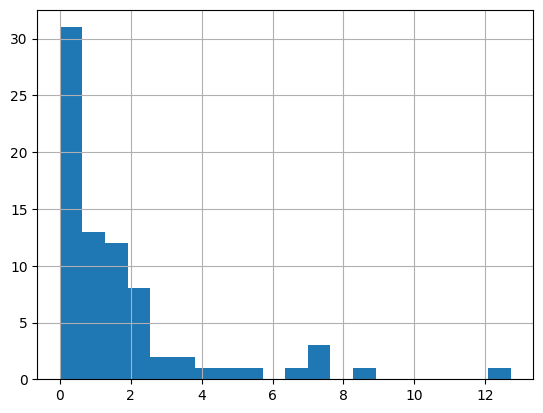

In [18]:
import matplotlib.pyplot as plt

ppva['P_VPA'].hist(bins=20)
plt.show()

In [19]:
print(ppva[ppva['P_VPA']> 10])

                  CNPJ     Ticker  Ano_Ref Data_Cotacao  Patrimonio_Liquido  \
48  89.637.490/0001-45  KLBN11.SA     2024   2025-03-01        8.637200e+09   

    Lucro_Liquido   ROE  Total_Acoes       VPA      Preco      P_VPA  
48   2.046945e+09  23.7   6179682031  1.397677  17.783827  12.723845  
